Files already downloaded and verified
Files already downloaded and verified


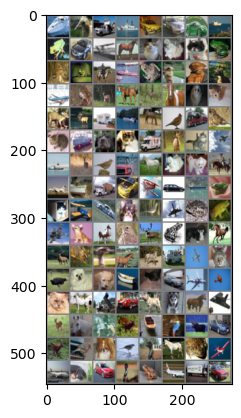

ship  bird  truck ship  car   car   car   ship  frog  car   plane horse cat   dog   dog   frog  deer  frog  horse ship  frog  dog   dog   deer  plane frog  deer  horse deer  horse dog   cat   deer  deer  truck ship  horse bird  truck bird  cat   car   dog   cat   truck deer  cat   plane ship  deer  bird  car   horse dog   dog   horse plane ship  truck car   plane car   ship  frog  cat   plane car   dog   bird  plane frog  frog  plane dog   horse bird  deer  frog  dog   horse deer  deer  bird  horse horse truck plane cat   bird  dog   dog   ship  cat   car   plane plane cat   horse truck car   dog   dog   horse plane deer  horse horse deer  ship  bird  deer  car   deer  bird  dog   bird  bird  horse frog  plane plane dog   car   bird  frog  plane truck car  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# functions to show an image
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [2]:
# initialize the network
import torch.nn as nn
import torch.nn.functional as F
import torch
from _model import ResNet20 


device=torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
net = ResNet20().to(device)

In [9]:
# 10 class
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
epochs = 200

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)



CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# first 5 classes
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.nn as nn

# 假设 train_transform 和 batch_size 已经定义
# ... (例如 batch_size = 64)
criterion = nn.CrossEntropyLoss()
epochs = 100

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)





# CIFAR-10 的所有类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 1. 定义我们想要的类别及其索引 (0到4)
TARGET_CLASSES_NAMES = classes[:5]
TARGET_CLASSES_INDICES = list(range(5))  # 0, 1, 2, 3, 4
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
# --- 载入原始完整训练集 ---
trainset_full = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', 
                                             train=True,
                                             download=True, 
                                             transform=train_transform)

# 2. 筛选数据集：获取所有属于目标类别的样本的索引
indices_to_keep = []
for i, label in enumerate(trainset_full.targets):
    # trainset_full.targets 是一个包含所有样本标签（0-9）的列表
    if label in TARGET_CLASSES_INDICES:
        indices_to_keep.append(i)

# 3. 创建子集 (Subset)
# Subset 类接受原始数据集和要保留的索引列表
trainset_subset = Subset(trainset_full, indices_to_keep)

# 4. 载入筛选后的数据
trainloader = torch.utils.data.DataLoader(trainset_subset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

# 5. 可选：检查结果
print(f"原始训练集大小: {len(trainset_full)}")
print(f"筛选后的训练集大小: {len(trainset_subset)}")
print(f"筛选后的类别: {TARGET_CLASSES_NAMES}")

# --- 测试集保持不变（使用您原来的代码，假设您不筛选测试集）---
testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
原始训练集大小: 50000
筛选后的训练集大小: 25000
筛选后的类别: ('plane', 'car', 'bird', 'cat', 'deer')
Files already downloaded and verified


In [ ]:
# last 5 classes
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

# 假设 train_transform 和 batch_size 已经定义
# ... (例如 batch_size = 64)
criterion = nn.CrossEntropyLoss()
epochs = 100

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# CIFAR-10 的所有类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 1. 定义我们想要的类别及其索引 (0到4)
TARGET_CLASSES_NAMES = classes[5:-1]
TARGET_CLASSES_INDICES = list(range(5,10))  #5,6,7,8,9,10

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
# --- 载入原始完整训练集 ---
trainset_full = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', 
                                             train=True,
                                             download=True, 
                                             transform=train_transform)

# 2. 筛选数据集：获取所有属于目标类别的样本的索引
indices_to_keep = []
for i, label in enumerate(trainset_full.targets):
    # trainset_full.targets 是一个包含所有样本标签（0-9）的列表
    if label in TARGET_CLASSES_INDICES:
        indices_to_keep.append(i)

# 3. 创建子集 (Subset)
# Subset 类接受原始数据集和要保留的索引列表
trainset_subset = Subset(trainset_full, indices_to_keep)

# 4. 载入筛选后的数据
trainloader = torch.utils.data.DataLoader(trainset_subset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

# 5. 可选：检查结果
print(f"原始训练集大小: {len(trainset_full)}")
print(f"筛选后的训练集大小: {len(trainset_subset)}")
print(f"筛选后的类别: {TARGET_CLASSES_NAMES}")

# --- 测试集保持不变（使用您原来的代码，假设您不筛选测试集）---
testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
原始训练集大小: 50000
筛选后的训练集大小: 25000
筛选后的类别: ('dog', 'frog', 'horse', 'ship')
Files already downloaded and verified


In [4]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 190== 189:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 190:.3f}')
            running_loss = 0.0
        scheduler.step()

print('Finished Training')

[1,   190] loss: 1.788
[1,   380] loss: 1.533
[2,   190] loss: 1.270
[2,   380] loss: 1.117
[3,   190] loss: 1.020
[3,   380] loss: 0.897
[4,   190] loss: 0.872
[4,   380] loss: 0.760
[5,   190] loss: 0.806
[5,   380] loss: 0.688
[6,   190] loss: 0.759
[6,   380] loss: 0.609
[7,   190] loss: 0.705
[7,   380] loss: 0.570
[8,   190] loss: 0.678
[8,   380] loss: 0.546
[9,   190] loss: 0.651
[9,   380] loss: 0.520
[10,   190] loss: 0.620
[10,   380] loss: 0.510
[11,   190] loss: 0.602
[11,   380] loss: 0.494
[12,   190] loss: 0.593
[12,   380] loss: 0.480
[13,   190] loss: 0.568
[13,   380] loss: 0.470
[14,   190] loss: 0.563
[14,   380] loss: 0.457
[15,   190] loss: 0.538
[15,   380] loss: 0.468
[16,   190] loss: 0.525
[16,   380] loss: 0.459
[17,   190] loss: 0.507
[17,   380] loss: 0.465
[18,   190] loss: 0.481
[18,   380] loss: 0.467
[19,   190] loss: 0.472
[19,   380] loss: 0.470
[20,   190] loss: 0.464
[20,   380] loss: 0.461
[21,   190] loss: 0.455
[21,   380] loss: 0.458
[22,   190

In [6]:
Path =f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_cifar10_cnn.pt"
torch.save(net.state_dict(), Path)

In [15]:
net = ResNet20().to(device)
Path= f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_l5cifar10_cnn.pt"
net.load_state_dict(torch.load(Path, weights_only=True))
# torch.save(net.backbone.state_dict(), "/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_f5cifar10_cnn_backbone.pth")

<All keys matched successfully>

In [16]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels =data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
# prepare to count predictions for each class

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels =data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 46 %
Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 86.6 %
Accuracy for class: frog  is 94.5 %
Accuracy for class: horse is 94.4 %
Accuracy for class: ship  is 94.5 %
Accuracy for class: truck is 91.6 %


Accuracy of the network on the 10000 test images: 44 %
Accuracy for class: plane is 91.7 %
Accuracy for class: car   is 98.4 %
Accuracy for class: bird  is 82.3 %
Accuracy for class: cat   is 79.9 %
Accuracy for class: deer  is 91.4 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


In [ ]:
# 86% accuracy

Accuracy for class: plane is 86.3 %
Accuracy for class: car   is 91.3 %
Accuracy for class: bird  is 82.8 %
Accuracy for class: cat   is 76.4 %
Accuracy for class: deer  is 87.9 %
Accuracy for class: dog   is 78.3 %
Accuracy for class: frog  is 89.1 %
Accuracy for class: horse is 91.2 %
Accuracy for class: ship  is 92.7 %
Accuracy for class: truck is 90.9 %
